In [2]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
import torch.nn.functional as F
import numpy as np
import torch.utils.data as Data
from PIL import  Image,ImageDraw
import numpy as np
import random
import cv2
from torchvision import models
from torchsummary import summary

Batch_Size = 50
num_epochs = 200
learning_rate = 1e-5
samples = 10000

data1 = []
data2= []


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% --  Generate dataset
cap = cv2.VideoCapture('video_drone_tank.avi')

uframes = []
ret, frame = cap.read()

uframes.append(frame)
flag = 0
z = 0
while(z<30):
    ret, frame = cap.read()
    #np_frame = cv2.imread('video', frame) # does not work
    #np_frame = np.asarray(cv2.GetMat(frame)) # does not work
    #print(np_frame.shape)
    for a in uframes:
        if (np.array(a).any() != None):
            print("a: ",np.shape(a))
            print("frame: ",np.shape(a))
            difference = cv2.subtract(np.array(a), np.array(frame))    
            result = not np.any(difference)
            #print("inside for")
            if result is True:
                flag = 1
                #print("setting flag")
                break
    if(not flag):
        #print("appending")
        uframes.append(frame)
    z+=1

for i,frame in enumerate(uframes):
    uframes[i] = cv2.resize(frame,(100,100))
    
print(np.shape(uframes[0]))
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()
print("length: ",len(uframes))
for i in range(samples):
    data1.append(np.array(np.transpose(np.asarray(uframes[i % len(uframes)]),(2,0,1)),dtype=np.float32))
    data2.append(np.array(np.transpose(np.asarray(uframes[(i+1) % len(uframes)]),(2,0,1)),dtype=np.float32))



#%%%%%%%%%%%%%%%%%%%%%%%%%%% Noisy data
img = Image.new('RGB', (100,100), color = '#9b7653')
# img.paste(im1,(5,75),im1)
# img.paste(im1,(10,55),im1)
# img.paste(im1,(25,50),im1)
# img.paste(im2,(75,5),im2)
# img.paste(im2,(60,30),im2)
# img.paste(im2,(90,20),im2)
# img.paste(im3,(75,60),im3)
# img.paste(im3,(60,80),im3)
im_n = np.reshape(img,(100,100,3))
b = np.asarray(im_n)
b = np.array(b, dtype=np.float32)
b = np.transpose(b,(2,0,1))
b = torch.from_numpy(b)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%       

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Data Preparation

y0 = np.asarray(data1)
y1 = np.asarray(data2)

#y0 = np.array(np.transpose(np.asarray(y0),(0,3,1,2)),dtype=np.float32)
#y1 = np.array(np.transpose(np.asarray(y1),(0,3,1,2)),dtype=np.float32)
print(np.shape(y0))

x = torch.from_numpy(y0)
y = torch.from_numpy(y1)


torch_dataset = Data.TensorDataset(x,y)


loader = Data.DataLoader(

    dataset=torch_dataset,

    batch_size=Batch_Size,

    shuffle=True,

    num_workers=0,

)


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Defining NN

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=10, stride=1)
        self.relu1 = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=5)

#         # Convolution 2
#         self.cnn2 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=5, stride=1, padding=2)
#         self.relu2 = nn.ReLU()

#         # Max pool 2
#         self.maxpool2 = nn.MaxPool2d(kernel_size=5)

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(10368, 15)
        self.sigmoid1 = nn.Sigmoid()

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max pool 1
        out = self.maxpool1(out)

        # Convolution 2 
        #out = self.cnn2(out)
        #out = self.relu2(out)

        # Max pool 2 
        #out = self.maxpool2(out)
        im_out = out
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        out = self.sigmoid1(out)
        return im_out,out
    
model = CNNModel()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Loss Function

def h_score(fx, gy):
 
    fx = fx - fx.mean(0)

    gy = gy - gy.mean(0)

    Nsamples = fx.size(0)
    #print(fx, np.shape(fx))
    #print(gy, np.shape(gy))
    #print(np.shape((torch.transpose(fx,3,2))),np.shape(fx))
    covf = torch.matmul(fx.t(), fx) / Nsamples

    covg = torch.matmul(gy.t(), gy) / Nsamples

    h = -2 * torch.mean((fx * gy).sum(1)) + (covf * covg).sum()

    return h


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)





for epoch in range(num_epochs):
    for x,y in loader:
        optimizer.zero_grad()
        # ===================forward=====================
        #loss = criterion(output1, img)
        loss = h_score(model(x)[1],model(y)[1])
        # ===================backward====================
 
        #optimizer_1.zero_grad()
        loss.backward()
        optimizer.step()
        #optimizer_1.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))
    print("shape: ", np.shape(model(x[0].reshape(1,3,100, 100))[0]))
#     print("x: ", model(x[0].reshape(1,3,100, 100)))
#     print("y:", model(y[0].reshape(1,3,100, 100)))
#     print("b:", model(b.reshape(1,3,100, 100)))


a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 720, 3)
a:  (1080, 720, 3)
frame:  (1080, 

epoch [16/200], loss:-0.5132
shape:  torch.Size([1, 32, 18, 18])
epoch [17/200], loss:-0.6374
shape:  torch.Size([1, 32, 18, 18])
epoch [18/200], loss:-0.4979
shape:  torch.Size([1, 32, 18, 18])
epoch [19/200], loss:-0.5238
shape:  torch.Size([1, 32, 18, 18])
epoch [20/200], loss:-0.6108
shape:  torch.Size([1, 32, 18, 18])
epoch [21/200], loss:-0.5175
shape:  torch.Size([1, 32, 18, 18])
epoch [22/200], loss:-0.4523
shape:  torch.Size([1, 32, 18, 18])
epoch [23/200], loss:-0.5423
shape:  torch.Size([1, 32, 18, 18])
epoch [24/200], loss:-0.5321
shape:  torch.Size([1, 32, 18, 18])
epoch [25/200], loss:-0.5723
shape:  torch.Size([1, 32, 18, 18])
epoch [26/200], loss:-0.5270
shape:  torch.Size([1, 32, 18, 18])
epoch [27/200], loss:-0.5431
shape:  torch.Size([1, 32, 18, 18])
epoch [28/200], loss:-0.5392
shape:  torch.Size([1, 32, 18, 18])
epoch [29/200], loss:-0.4908
shape:  torch.Size([1, 32, 18, 18])
epoch [30/200], loss:-0.5156
shape:  torch.Size([1, 32, 18, 18])
epoch [31/200], loss:-0.4

epoch [142/200], loss:-1.6949
shape:  torch.Size([1, 32, 18, 18])
epoch [143/200], loss:-1.8408
shape:  torch.Size([1, 32, 18, 18])
epoch [144/200], loss:-1.7754
shape:  torch.Size([1, 32, 18, 18])
epoch [145/200], loss:-1.5825
shape:  torch.Size([1, 32, 18, 18])
epoch [146/200], loss:-1.8862
shape:  torch.Size([1, 32, 18, 18])
epoch [147/200], loss:-1.7940
shape:  torch.Size([1, 32, 18, 18])
epoch [148/200], loss:-1.7953
shape:  torch.Size([1, 32, 18, 18])
epoch [149/200], loss:-1.6936
shape:  torch.Size([1, 32, 18, 18])
epoch [150/200], loss:-1.7698
shape:  torch.Size([1, 32, 18, 18])
epoch [151/200], loss:-1.5848
shape:  torch.Size([1, 32, 18, 18])
epoch [152/200], loss:-1.7001
shape:  torch.Size([1, 32, 18, 18])
epoch [153/200], loss:-1.7668
shape:  torch.Size([1, 32, 18, 18])
epoch [154/200], loss:-1.7851
shape:  torch.Size([1, 32, 18, 18])
epoch [155/200], loss:-1.7902
shape:  torch.Size([1, 32, 18, 18])
epoch [156/200], loss:-1.6700
shape:  torch.Size([1, 32, 18, 18])
epoch [157

In [18]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

tank_info_panel = 0
drone_info_panel = 23

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position

#Blank
img = uframes[0]
z = Image.fromarray(img)
z.show()
data3=[]
data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
y3 = np.array(data3)
x_1 = torch.from_numpy(y3)
output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
output_tank = output[0][tank_info_panel]
val,pos = val_pos(output_tank)
print("Blank: ",val,pos)
output_drone = output[0][drone_info_panel]
val,pos = val_pos(output_drone)
print("Blank: ",val,pos)


#Tank
img = uframes[1]
z = Image.fromarray(img)
z.show()
data3=[]
data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
y3 = np.array(data3)
x_1 = torch.from_numpy(y3)
output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
output_tank = output[0][tank_info_panel]
val,pos = val_pos(output_tank)
print("Tank: ",val,pos)
output_drone = output[0][drone_info_panel]
val,pos = val_pos(output_drone)
print("Tank: ",val,pos)


#Drone
img = uframes[2]
z = Image.fromarray(img)
z.show()
data3=[]
data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
y3 = np.array(data3)
x_1 = torch.from_numpy(y3)
output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
output_tank = output[0][tank_info_panel]
val,pos = val_pos(output_tank)
print("Drone: ",val,pos)
output_drone = output[0][drone_info_panel]
val,pos = val_pos(output_drone)
print("Drone: ",val,pos)


#Tank and Drone
img = uframes[3]
z = Image.fromarray(img)
z.show()
data3=[]
data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
y3 = np.array(data3)
x_1 = torch.from_numpy(y3)
output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
output_tank = output[0][tank_info_panel]
val,pos = val_pos(output_tank)
print("TD: ",val,pos)
output_drone = output[0][drone_info_panel]
val,pos = val_pos(output_drone)
print("TD: ",val,pos)



Blank:  149.64612 (10, 13)
Blank:  438.28845 (12, 12)
Tank:  229.57103 (5, 4)
Tank:  592.07043 (12, 12)
Drone:  149.64612 (10, 13)
Drone:  617.1903 (0, 4)
TD:  229.57103 (5, 4)
TD:  770.9724 (0, 4)


In [64]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)


def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position

for i in range(32):

    tank_info_panel = i
    drone_info_panel = i
    #Blank
    img = uframes[0]
    z = Image.fromarray(img)
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Blank: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Blank: ",val,pos)


    #Tank
    img = uframes[1]
    z = Image.fromarray(img)
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Tank: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Tank: ",val,pos)


    #Drone
    img = uframes[2]
    z = Image.fromarray(img)
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Drone: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Drone: ",val,pos)


    #Tank and Drone
    img = uframes[3]
    z = Image.fromarray(img)
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("TD: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("TD: ",val,pos)
    
    print("done ",i)
    print("++++++++++++++++++++++++++++++++++++++++++++")

Blank:  0.0 (0, 0)
Blank:  0.0 (0, 0)
Tank:  0.0 (0, 0)
Tank:  0.0 (0, 0)
Drone:  0.0 (0, 0)
Drone:  0.0 (0, 0)
TD:  0.0 (0, 0)
TD:  0.0 (0, 0)
done  0
++++++++++++++++++++++++++++++++++++++++++++
Blank:  833.20825 (11, 3)
Blank:  833.20825 (11, 3)
Tank:  1070.0562 (5, 2)
Tank:  1070.0562 (5, 2)
Drone:  934.72766 (0, 3)
Drone:  934.72766 (0, 3)
TD:  1171.5754 (5, 2)
TD:  1171.5754 (5, 2)
done  1
++++++++++++++++++++++++++++++++++++++++++++
Blank:  1548.6594 (11, 3)
Blank:  1548.6594 (11, 3)
Tank:  1727.739 (11, 3)
Tank:  1727.739 (11, 3)
Drone:  1689.2192 (11, 3)
Drone:  1689.2192 (11, 3)
TD:  1868.299 (11, 3)
TD:  1868.299 (11, 3)
done  2
++++++++++++++++++++++++++++++++++++++++++++
Blank:  723.1429 (7, 10)
Blank:  723.1429 (7, 10)
Tank:  799.8422 (7, 10)
Tank:  799.8422 (7, 10)
Drone:  777.3772 (7, 10)
Drone:  777.3772 (7, 10)
TD:  854.0766 (7, 10)
TD:  854.0766 (7, 10)
done  3
++++++++++++++++++++++++++++++++++++++++++++
Blank:  246.30855 (11, 13)
Blank:  246.30855 (11, 13)
Tank:  5

In [72]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

tank_info_panel = 4
drone_info_panel = 24

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position
dronec=[]
tankc=[]
#Blank
for i in range(12):
    #x = cv2.imread(r"C:\Users\darshan19\Desktop\AoI\CNN\Images1\0b.png",-1)
    #x = cv2.resize(x,(100,100))
    img = uframes[i]
    #print(np.shape(img))
    z = Image.fromarray(img)
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    #print(np.shape(x_1))
    output = model(x_1.reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val_tank,pos_tank = val_pos(output_tank)
    print(i)
    output_drone = output[0][drone_info_panel]
    val_drone,pos_drone = val_pos(output_drone)
    if val_tank>500:
        print("tank present")
        print("Tank info: ",val_tank,pos_tank)
        tankc.append(pos_tank)
    if val_drone>770:
        print("drone present")
        print("Drone info: ",val_drone,pos_drone)
        dronec.append(pos_drone)

0
1
tank present
Tank info:  520.7602 (6, 2)
2
drone present
Drone info:  781.4645 (1, 4)
3
tank present
Tank info:  634.67224 (6, 2)
drone present
Drone info:  942.7866 (1, 4)
4
tank present
Tank info:  654.7293 (6, 8)
drone present
Drone info:  927.96313 (1, 4)
5
tank present
Tank info:  642.7981 (6, 13)
drone present
Drone info:  985.1527 (1, 4)
6
tank present
Tank info:  722.30286 (6, 2)
drone present
Drone info:  938.44824 (5, 1)
7
tank present
Tank info:  740.57965 (6, 8)
drone present
Drone info:  860.5968 (5, 7)
8
tank present
Tank info:  730.4288 (6, 13)
drone present
Drone info:  976.33765 (5, 12)
9
tank present
Tank info:  669.9697 (6, 2)
drone present
Drone info:  1017.36505 (13, 15)
10
tank present
Tank info:  690.02686 (6, 8)
drone present
Drone info:  1002.5415 (13, 15)
11
tank present
Tank info:  678.09564 (6, 13)
drone present
Drone info:  1059.7312 (13, 15)


In [58]:
im1 = Image.open('tree1.png')
im1 = im1.resize((100,100))

imt = Image.open('tank.png')
imt = imt.resize((100,100))
def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position


im2 = Image.open('tree2.png')
im2 = im2.resize((100,100))

im3 = Image.open('tree3.png')
im3 = im3.resize((100,100))

im_drone = Image.open('drone4-1.png')
im_drone = im_drone.resize((200,200))

imb = Image.open('bullet.png')
imb = imb.resize((40,40))

tank_info_panel = 4
drone_info_panel = 24

img_blank = Image.new('RGB', (720, 1080), color = '#9b7653')
img_blank.paste(im1,(5,75),im1)
img_blank.paste(im1,(450,550),im1)
img_blank.paste(im1,(205,720),im1)
img_blank.paste(im2,(500,900),im2)
img_blank.paste(im2,(650,750),im2)
img_blank.paste(im2,(320,440),im2)
img_blank.paste(im3,(100,600),im3)
img_blank.paste(im3,(440,620),im3)
img_blank.paste(im3,(300,150),im3)
#img_blank.paste(imt.rotate(180),(800,500),imt.rotate(180))
img_blank.show()
img_blank = np.asarray(img_blank)

img_blank = cv2.resize(img_blank,(100,100))

pil = np.array(np.transpose(np.asarray(img_blank),(2,0,1)),dtype=np.float32)

pil = torch.from_numpy(pil)

print(np.shape(pil))
output = model(pil.reshape(1,3,100, 100))[0].detach().numpy()
output_tank = output[0][tank_info_panel]
val_tank,pos_tank = val_pos(output)

output_drone = output[0][drone_info_panel]
val_drone,pos_drone = val_pos(output_drone)
if val_tank>500:
    print("tank present")
    print("Tank info: ",val_tank,pos_tank)
if val_drone>770:
    print("drone present")
    print("Drone info: ",val_drone,pos_drone)

torch.Size([3, 100, 100])
tank present
Tank info:  50095.812 (0, 6, 17, 15)


In [3]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

for i in range(12):
    k = uframes[i]
    #k.show()
    v = np.array(np.transpose(np.asarray(uframes[i]),(2,0,1)),dtype=np.float32)
    v = torch.from_numpy(v)
    filename = "Marginalization_Simple-increased_channels-32/ref_image_new_" + str(i) + ".txt"
    file = open(filename, 'w')
    file.write(str(model(v.reshape(1,3,100, 100))[0].detach().numpy()))
    file.close()


In [4]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

filename = "Marginalization_Simple-increased_channels-32/fc_weights.txt"
file = open(filename, 'w')
file.write(str(model.fc1.weight.detach().numpy()))
print(np.shape(model.fc1.weight.detach().numpy()))
file.close()


(15, 10368)


In [4]:
##Weights

import operator
k=model.fc1.weight.detach().numpy()
for i in range(15):
    index, value = max(enumerate(k[i]), key=operator.itemgetter(1))
    print("FC - Feature "+ "i: ",index,value)
    print("CNN value: ", )

FC - Feature i:  684 0.041578084
CNN value: 
FC - Feature i:  684 0.051804464
CNN value: 
FC - Feature i:  360 0.04816093
CNN value: 
FC - Feature i:  492 0.035558272
CNN value: 
FC - Feature i:  478 0.06459166
CNN value: 
FC - Feature i:  585 0.049136233
CNN value: 
FC - Feature i:  492 0.081621096
CNN value: 
FC - Feature i:  360 0.065480515
CNN value: 
FC - Feature i:  585 0.04792851
CNN value: 
FC - Feature i:  492 0.06556648
CNN value: 
FC - Feature i:  684 0.035789683
CNN value: 
FC - Feature i:  684 0.034514345
CNN value: 
FC - Feature i:  817 0.043642323
CNN value: 
FC - Feature i:  492 0.088237286
CNN value: 
FC - Feature i:  492 0.09752004
CNN value: 


In [6]:
import operator
import sys
#t1d1
img_blank = Image.new('RGB', (100, 100), color = '#9b7653')
img_blank.paste(imt.rotate(180),(10,30),imt.rotate(180))
# img_blank.paste(im_drone.resize((10,10)),(2,10),im_drone.resize((10,10)))

# #t2d2
# img_blank.paste(imt.rotate(180),(30,30),imt.rotate(180))
# draw = ImageDraw.Draw(img_blank)
# draw.ellipse((35,35,38,38), fill=(255, 0, 0))
# img_blank.paste(im_drone.resize((10,10)),(35,45),im_drone.resize((10,10)))
# draw.ellipse((40,50,43,53), fill=(50, 182, 150))

# #t3d3
# img_blank.paste(imt.rotate(180),(50,30),imt.rotate(180))
# img_blank.paste(imb.resize((2,2)),(54,40),imb.resize((2,2)))
# img_blank.paste(im_drone.resize((10,10)),(50,70),im_drone.resize((10,10)))
# img_blank.paste(imb.resize((2,2)),(56,81),imb.resize((2,2)))

v = np.array(np.transpose(np.asarray(img_blank),(2,0,1)),dtype=np.float32)
v = torch.from_numpy(v)
k = model(v.reshape(1,3,100, 100))[0].view(model(v.reshape(1,3,100, 100))[0].size(0), -1).detach().numpy()

filename = "Marginalization_Simple/flattened_tank_pos_1.txt"
file = open(filename, 'w')
file.write(str(k))
file.close()


# print(np.shape(k))
# index, value = max(enumerate(k), key=operator.itemgetter(1))
# print(index,value)


import operator
p=model.fc1.weight.detach().numpy()
for i in range(15):
    index, value = max(enumerate(p[i]), key=operator.itemgetter(1))
    print("FC - Feature "+ str(i) +" : ",index,value)
    print
    print("CNN value: ",k[0][index] )

FC - Feature 0 :  684 0.041578084
CNN value:  17.59211
FC - Feature 1 :  684 0.051804464
CNN value:  17.59211
FC - Feature 2 :  360 0.04816093
CNN value:  0.53643996
FC - Feature 3 :  492 0.035558272
CNN value:  0.53643996
FC - Feature 4 :  478 0.06459166
CNN value:  0.53643996
FC - Feature 5 :  585 0.049136233
CNN value:  0.53643996
FC - Feature 6 :  492 0.081621096
CNN value:  0.53643996
FC - Feature 7 :  360 0.065480515
CNN value:  0.53643996
FC - Feature 8 :  585 0.04792851
CNN value:  0.53643996
FC - Feature 9 :  492 0.06556648
CNN value:  0.53643996
FC - Feature 10 :  684 0.035789683
CNN value:  17.59211
FC - Feature 11 :  684 0.034514345
CNN value:  17.59211
FC - Feature 12 :  817 0.043642323
CNN value:  17.59211
FC - Feature 13 :  492 0.088237286
CNN value:  0.53643996
FC - Feature 14 :  492 0.09752004
CNN value:  0.53643996


In [21]:

import random


p=0
class_data = []
while(p<len(uframes)):
    data3=[]
    print(p)
    for i in range(50):
        img = uframes[p]
        data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
        y3 = np.array(data3)
        x_1 = torch.from_numpy(y3)
        temp = model(x_1[i].reshape(1,3,100,100))[1]
        #print(temp)
        class_data.append((list(temp.detach().numpy()[0]),p))
    p+=1
    print(len(class_data))

random.shuffle(class_data)
random.shuffle(class_data)

print("length ", len(class_data))

0
50
1
100
2
150
3
200
4
250
5
300
6
350
7
400
8
450
9
500
10
550
11
600
length  600


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from colorama import init  
import time
import cv2

print(np.shape(uframes[0]))


#z  = np.array(np.transpose(np.asarray(z),(2,0,1)),dtype=np.float32)
# import some data to play with
print("Length of Class data: ", len(class_data))
# Take the first two features. We could avoid this by using a two-dim dataset
X = [(i[0]) for i in class_data]
y = [i[1] for i in class_data]
#print(X,np.shape(X))
#print(y,np.shape(y))
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
clf = svm.SVC(kernel='linear', C=C)
clf = clf.fit(X, y)
data3=[]
y3=0

n1 = "\x1b[31m\"Drone Stationary, Tank Firing\"\x1b[0m"
n2 = "\x1b[31m\"Drone Reloading, Tank Firing\"\x1b[0m"
n3 = "\x1b[31m\"Drone Firing, Tank Stationary\"\x1b[0m"
n4 = "\x1b[31m\"Drone Firing, Tank Reloading\"\x1b[0m"
n5 = "\x1b[31m\"Drone Firing, Tank Firing\"\x1b[0m"

names = ['Just Background','Only Tank moving', 'Only Drone Moving', 'Drone stationary, Tank Stationary', 'Drone Stationary, Tank Reloading' ,
         n1, 'Drone reloading, Tank Stationary', 'Drone reloading, Tank Reloading', n2 , n3,n4,n5]

print("Start")

img_blank = Image.new('RGB', (100, 100), color = '#9b7653')
img_blank.paste(im1,(5,7),im1)
img_blank.paste(im1,(45,55),im1)
img_blank.paste(im1,(25,72),im1)
img_blank.paste(im2,(50,90),im2)
img_blank.paste(im2,(60,75),im2)
img_blank.paste(im2,(30,40),im2)
img_blank.paste(im3,(10,60),im3)
img_blank.paste(im3,(44,62),im3)
img_blank.paste(im3,(30,15),im3)
img_blank.paste(imt.rotate(180),(50,30),imt.rotate(180))
img_blank.paste(imb.resize((2,2)),(54,40),imb.resize((2,2)))
#img_blank.paste(im_drone.resize((10,10)),(50,70),im_drone.resize((10,10)))
#img_blank.paste(imb.resize((2,2)),(56,81),imb.resize((2,2)))

for i in range(12):
    #z = cv2.imread('Images_100/0a.png')
    #l = Image.fromarray(z)
#     print("shape of z", np.shape(z),type(z))
#     #l.show()
#     #z  = cv2.resize(z,(100,100))
#     img = uframes[i]
#     print(np.shape(img))
#     img.show()
#     data3.append(np.array(np.transpose(np.asarray(uframes[i]),(2,0,1)),dtype=np.float32))
#     y3 = np.array(data3)
#     x_1 = torch.from_numpy(y3)
# #     random_img = random.choice(x)
# #     print("random", np.shape(random_img),type(random_img))
# #     show = random_img.detach().numpy() * 255
# #     show = np.array(np.transpose(show,(1,2,0)),dtype=np.uint8)
# #     print("show", np.shape(show),type(show))
# #     ms = Image.fromarray(show)
# #     ms.show()
#     temp = model(x_1[i].reshape(1,3,100,100))[1]
#     temp = temp.detach().numpy()
#     img_blank.show()
#     #print(temp)
#     z = clf.predict(temp)
#     print(names[z[0]])
    img = uframes[i]
    print(np.shape(img))
    img.show()
    #ms = Image.fromarray(z)
    #ms.show()
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    temp = model(x_1[i].reshape(1,3,100,100))[1]
    temp = temp.detach().numpy()
    print(temp)
    z = clf.predict(temp)
    print(names[z[0]])
    
    

(100, 100, 3)
Length of Class data:  600
Start
(100, 100, 3)
[[5.69654167e-01 9.99462187e-01 5.63863292e-02 4.24214751e-01
  9.99946237e-01 3.76719624e-01 9.24754981e-03 9.96866763e-01
  3.24720666e-02 6.23485744e-01 9.99366581e-01 1.33173708e-05
  9.99919176e-01 1.10880566e-04 7.16020440e-05]]
Just Background
(100, 100, 3)
[[1.0693459e-01 9.7853309e-01 6.2482929e-01 8.8721722e-01 9.2732191e-01
  3.8686104e-04 4.0334295e-03 9.7163016e-01 4.2039016e-01 9.9970645e-01
  9.6105587e-01 4.5536429e-02 9.1955161e-01 2.7226047e-03 7.8407951e-02]]
Only Tank moving
(100, 100, 3)
[[7.3534204e-03 9.9773276e-01 9.8508829e-01 9.9262118e-01 4.5104271e-01
  3.5262175e-04 1.2917872e-04 7.4658793e-01 9.1725689e-01 9.9936992e-01
  9.9860114e-01 5.1300049e-01 5.2829486e-01 2.9081654e-02 4.6734187e-01]]
Only Drone Moving
(100, 100, 3)
[[6.6964526e-04 9.1521192e-01 9.9945718e-01 9.9930429e-01 5.6288450e-04
  2.2586556e-07 5.6052031e-05 2.4077968e-01 9.9584311e-01 9.9999964e-01
  9.1780317e-01 9.9973506e-01 1

In [66]:
print(len(uframes
         ))

12


In [44]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

img_blank = Image.new('RGB', (100, 100), color = '#9b7653')
img_blank.paste(im1,(5,7),im1)
img_blank.paste(im1,(45,55),im1)
img_blank.paste(im1,(25,72),im1)
img_blank.paste(im2,(50,90),im2)
img_blank.paste(im2,(60,75),im2)
img_blank.paste(im2,(30,40),im2)
img_blank.paste(im3,(10,60),im3)
img_blank.paste(im3,(44,62),im3)
img_blank.paste(im3,(30,15),im3)
img_blank.paste(imt.rotate(180),(60,60),imt.rotate(180))
#img_blank.paste(im_drone.resize((10,10)),(10,30),im_drone.resize((10,10)))
#img_blank.paste(imt.rotate(180),(30,30),imt.rotate(180))
#draw = ImageDraw.Draw(img_blank)
#draw.ellipse((60,60,68,68), fill=(255, 0, 0))
# img_blank.paste(im_drone.resize((10,10)),(35,45),im_drone.resize((10,10)))
#draw = ImageDraw.Draw(img_blank)
#draw.ellipse((10,30,18,38), fill=(50, 182, 150))
#img_blank.paste(imt.rotate(180),(50,30),imt.rotate(180))
#img_blank.paste(imb.resize((2,2)),(54,40),imb.resize((2,2)))
#img_blank.paste(im_drone.resize((10,10)),(50,70),im_drone.resize((10,10)))
#img_blank.paste(imb.resize((2,2)),(56,81),imb.resize((2,2)))
img_blank.show()
pil = np.array(np.transpose(np.asarray(img_blank),(2,0,1)),dtype=np.float32)
pil = torch.from_numpy(pil)
filename = "lesser_15_features/testing.txt"
file = open(filename, 'w')
file.write(str(model(pil.reshape(1,3,100, 100))[0].detach().numpy()))
file.close()

[(6, 2), (6, 2), (6, 8), (6, 13), (6, 2), (6, 8), (6, 13), (6, 2), (6, 8), (6, 13)]


<function matplotlib.pyplot.show(*args, **kw)>

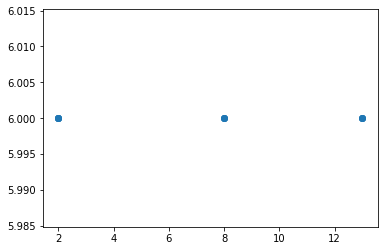

In [81]:
import numpy as np
import matplotlib.pyplot as plt
print(tankc)
x = [tankc[i][0] for i in range(len(tankc))]
y = [tankc[i][1] for i in range(len(tankc))]
plt.scatter(y,x)

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

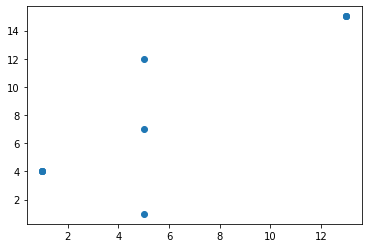

In [85]:
import numpy as np
import matplotlib.pyplot as plt
x = [dronec[i][0] for i in range(len(dronec))]
y = [dronec[i][1] for i in range(len(dronec))]
plt.scatter(x,y)
plt.show

In [23]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)   

from PIL import  Image,ImageDraw
for i in range(12):
    img = uframes[i]
    z = Image.fromarray(img)
    z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    temp = model(x_1[0].reshape(1,3,100,100))[0].detach().numpy()
    filename = "Marginalization_Simple-increased_channels-32-video/uframe_"+str(i)+".txt"
    file = open(filename, 'w')
    file.write(str(model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()))
    file.close()